<a href="https://colab.research.google.com/github/FranciscoMedellin/MNA_NLP/blob/main/Equipo60_chatbot_LLM_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Procesamiento de Lenguaje Natural**

## Maestría en Inteligencia Artificial Aplicada
#### Tecnológico de Monterrey
#### Prof Luis Eduardo Falcón Morales

### **Actividad en Equipos: sistema LLM + RAG**

* **Nombres y matrículas:**

- Mardonio Manuel Román Ramírez – A01795265



- Diego Andrés Bernal Díaz – A01795975



- Laura Patricia Martinez Treviño – A01795967



- Francisco Medellin Zertuche - A01794044



* **Número de Equipo: 60**


## **Introducción de la problemática a resolver.**

Los Modelos de Lenguaje Grandes (LLMs) convencionales enfrentan limitaciones críticas como el conocimiento estático y la tendencia a "alucinar" información, lo que reduce su fiabilidad. La arquitectura de Generación Aumentada por Recuperación (RAG) resuelve este problema al conectar dinámicamente al LLM con una base de conocimiento externa y verificable, creando sistemas de IA más precisos y actualizables.

Para demostrar esta solución de manera práctica, este proyecto construye un chatbot RAG cuyo tema central es, precisamente, la propia tecnología RAG. Este enfoque meta-referencial es deliberado: al poblar su base de conocimiento con documentos sobre su propio funcionamiento, el chatbot se convierte en una herramienta autoexplicativa. Su capacidad para responder correctamente sobre qué es RAG, sus componentes y sus ventajas es la prueba más directa de su eficacia y, a la vez, una herramienta educativa interactiva.

In [ ]:
# Instalar dependencias (ejecutar en Colab)
#!pip install gradio openai sentence-transformers
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 42.7 MB/s eta 0:00:00


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Tuple
import openai
from sentence_transformers import SentenceTransformer
import faiss
import pickle
from dataclasses import dataclass
import gradio as gr
import tempfile
import io


In [ ]:
from google.colab import userdata

## Sistema RAG + LLM

### Clase de estructura para almacenar documentos

In [ ]:
@dataclass
class Document:
    id: str
    content: str
    metadata: Dict[str, Any] = None


## Selección de los modelos utilizados:

La elección de gpt-3.5-turbo como el Modelo de Lenguaje Grande (LLM) es una decisión pragmática y eficiente para este proyecto. Su función principal, como se define en el prompt del sistema dentro de la clase RAGChatbot, no es generar conocimiento nuevo, sino sintetizar y reformular la información extraída de los documentos de contexto. Para esta tarea de "Retrieval Augmented Generation", gpt-3.5-turbo ofrece un equilibrio ideal entre costo, velocidad y capacidad. Es significativamente más rápido y económico que modelos más grandes como GPT-4, lo cual es crucial para una aplicación interactiva con Gradio, garantizando respuestas ágiles. Al mismo tiempo, es lo suficientemente potente para seguir instrucciones complejas, como basarse únicamente en el contexto proporcionado y responder de manera coherente, lo que lo convierte en la opción perfecta para un prototipo robusto sin incurrir en altos costos o latencia.

Por otro lado, seleccionar all-MiniLM-L6-v2 como el modelo de embeddings es una elección estratégica para la parte de "recuperación" (Retrieval) del sistema. Este modelo, cargado a través de la librería SentenceTransformer, se ejecuta localmente en el entorno de Colab, lo que significa que no tiene costos de API asociados y su rendimiento es muy rápido. Al ser un modelo "Mini", está optimizado para ser ligero y eficiente, funcionando perfectamente en CPU (como lo demuestra la instalación de faiss-cpu) sin sacrificar la calidad semántica de los vectores que genera. Para una base de conocimientos del tamaño manejado en este ejercicio, all-MiniLM-L6-v2 proporciona una capacidad de búsqueda por similitud de alta calidad, permitiendo encontrar los documentos más relevantes de forma rápida y precisa, lo cual es fundamental para que el LLM reciba el contexto correcto y pueda generar una respuesta acertada.

### Clase del Chatbot

In [ ]:
class RAGChatbot:
    def __init__(self,
                 openai_api_key: str = None,
                 embedding_model: str = "all-MiniLM-L6-v2",
                 llm_model: str = "gpt-3.5-turbo"):
        """Inicializa el chatbot RAG"""

        # Configurar OpenAI
        if openai_api_key:
            openai.api_key = openai_api_key
        else:
            openai.api_key = userdata.get('MNA_NLP_API_KEY')

        self.llm_model = llm_model

        # Inicializar modelo de embeddings
        print("Cargando modelo de embeddings...")
        self.embedding_model = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedding_model.get_sentence_embedding_dimension()

        # Inicializar base de datos vectorial
        self.index = faiss.IndexFlatIP(self.embedding_dim)
        self.documents = []
        self.chat_history = []

        print("Chatbot RAG inicializado correctamente!")

    def add_documents(self, documents: List[str], metadata: List[Dict] = None):
        """Añade documentos a la base de conocimiento"""
        if not documents:
            return "No se proporcionaron documentos"

        print(f"Procesando {len(documents)} documentos...")

        try:
            # Generar embeddings
            embeddings = self.embedding_model.encode(documents, normalize_embeddings=True)

            # Añadir al índice FAISS
            self.index.add(embeddings.astype('float32'))

            # Almacenar documentos
            for i, doc in enumerate(documents):
                doc_metadata = metadata[i] if metadata and i < len(metadata) else {}
                document = Document(
                    id=str(len(self.documents)),
                    content=doc,
                    metadata=doc_metadata
                )
                self.documents.append(document)

            result = f"Se añadieron {len(documents)} documentos. Total: {len(self.documents)}"
            print(result)
            return result

        except Exception as e:
            error = f"Error al procesar documentos: {str(e)}"
            print(error)
            return error

    def search_similar_documents(self, query: str, k: int = 3) -> List[Document]:
        """Busca documentos similares a la query"""
        if len(self.documents) == 0:
            return []

        # Generar embedding de la query
        query_embedding = self.embedding_model.encode([query], normalize_embeddings=True)

        # Buscar documentos similares
        scores, indices = self.index.search(query_embedding.astype('float32'), k)

        # Retornar documentos relevantes
        relevant_docs = []
        for i, score in zip(indices[0], scores[0]):
            if i < len(self.documents) and score > 0.1:
                doc = self.documents[i]
                doc.metadata = doc.metadata or {}
                doc.metadata['similarity_score'] = float(score)
                relevant_docs.append(doc)

        return relevant_docs

    def generate_response(self, query: str, context_docs: List[Document]) -> str:
        """Genera respuesta usando el contexto recuperado"""
        context = "\n\n".join([f"Documento {i+1}: {doc.content}"
                              for i, doc in enumerate(context_docs)])

        system_prompt = """Eres un asistente útil que responde preguntas basándose en el contexto proporcionado.

                            INSTRUCCIONES:
                            - Usa ÚNICAMENTE la información del contexto para responder
                            - Si la información no está en el contexto, di "No tengo información suficiente para responder esa pregunta"
                            - Sé conciso pero completo en tus respuestas
                            - Mantén un tono amigable y profesional
                            - Si es relevante, menciona el documento de referencia"""

        user_prompt = f"""Contexto: {context}

                          Pregunta: {query}

                          Respuesta:"""

        try:
            response = openai.chat.completions.create(
                model=self.llm_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.7,
                max_tokens=500
            )

            return response.choices[0].message.content.strip()

        except Exception as e:
            return f"Error al generar respuesta: {str(e)}"

    def chat(self, query: str, k: int = 3) -> Tuple[str, List[str]]:
        """Función principal de chat que retorna respuesta y fuentes"""
        if not query.strip():
            return "Por favor, escribe una pregunta.", []

        # Buscar documentos relevantes
        relevant_docs = self.search_similar_documents(query, k)

        if not relevant_docs:
            response = "No encontré información relevante en mi base de conocimiento para responder tu pregunta."
            sources = []
        else:
            # Generar respuesta
            response = self.generate_response(query, relevant_docs)

            # Preparar fuentes
            sources = []
            for i, doc in enumerate(relevant_docs):
                score = doc.metadata.get('similarity_score', 0)
                source_text = f"📄 Fuente {i+1} (Similitud: {score:.3f}):\n{doc.content[:300]}{'...' if len(doc.content) > 300 else ''}"
                sources.append(source_text)

        # Guardar en historial
        self.chat_history.append({"user": query, "bot": response})

        return response, sources

    def get_stats(self) -> str:
        """Retorna estadísticas de la base de conocimiento"""
        if not self.documents:
            return "Base de conocimiento vacía"

        total_docs = len(self.documents)
        total_chars = sum(len(doc.content) for doc in self.documents)
        avg_chars = total_chars / total_docs if total_docs > 0 else 0

        return f"""**Estadísticas de la Base de Conocimiento:**

                • **Total de documentos:** {total_docs}
                • **Total de caracteres:** {total_chars:,}
                • **Promedio por documento:** {avg_chars:.0f} caracteres
                • **Consultas realizadas:** {len(self.chat_history)}"""

Función para iniciar el chatbot

In [ ]:
chatbot = None

def initialize_chatbot(api_key: str) -> str:
    """Inicializa el chatbot con la API key"""
    global chatbot

    if not api_key.strip():
        return "Por favor, proporciona una API key de OpenAI"

    try:
        chatbot = RAGChatbot(openai_api_key=api_key.strip())
        return "Chatbot inicializado correctamente!"
    except Exception as e:
        return f"Error al inicializar: {str(e)}"

### Funciones para añadir documentos al sistema, antes y durante la ejecución.

In [ ]:
def add_text_documents(text_input: str) -> Tuple[str, str]:
    """Añade documentos desde texto"""
    global chatbot

    if chatbot is None:
        return "Primero inicializa el chatbot con tu API key", ""

    if not text_input.strip():
        return "Por favor, proporciona texto para añadir", ""

    # Dividir texto en párrafos
    documents = [p.strip() for p in text_input.split('\n\n') if p.strip()]

    if not documents:
        return "No se encontraron párrafos válidos", ""

    result = chatbot.add_documents(documents)
    stats = chatbot.get_stats()

    return result, stats

def upload_file_documents(file) -> Tuple[str, str]:
    """Procesa archivo subido"""
    global chatbot

    if chatbot is None:
        return "Primero inicializa el chatbot con tu API key", ""

    if file is None:
        return "No se subió ningún archivo", ""

    try:
        # Leer contenido del archivo
        if file.name.endswith('.txt'):
            content = file.read().decode('utf-8')
            documents = [p.strip() for p in content.split('\n\n') if p.strip()]
        elif file.name.endswith('.csv'):
            df = pd.read_csv(file.name)
            # Asumir que hay una columna 'text' o usar la primera columna
            text_column = 'text' if 'text' in df.columns else df.columns[0]
            documents = df[text_column].astype(str).tolist()
        else:
            return "Formato de archivo no soportado. Usa .txt o .csv", ""

        if not documents:
            return "No se encontraron documentos válidos en el archivo", ""

        result = chatbot.add_documents(documents)
        stats = chatbot.get_stats()

        return result, stats

    except Exception as e:
        return f"Error al procesar archivo: {str(e)}", ""

# Función para precargar documentos
def preload_documents(api_key: str, documents: List[str] = None):
    """
    Precarga documentos antes de lanzar la interfaz

    Args:
        api_key: Tu API key de OpenAI
        documents: Lista de documentos a precargar
    """
    global chatbot

    print("Inicializando chatbot...")
    chatbot = RAGChatbot(openai_api_key=api_key)

    if documents:
        print(f"Precargando {len(documents)} documentos...")
        result = chatbot.add_documents(documents)
        print(result)
        print(chatbot.get_stats())
    else:
        print("Chatbot inicializado sin documentos precargados")

    return chatbot

# Función para añadir más documentos después de la inicialización
def add_more_documents(new_documents: List[str]):
    """Añade más documentos al chatbot ya inicializado"""
    global chatbot

    if chatbot is None:
        print("Primero debes inicializar el chatbot con preload_documents()")
        return

    print(f"📚 Añadiendo {len(new_documents)} documentos adicionales...")
    result = chatbot.add_documents(new_documents)
    print(result)
    print(chatbot.get_stats())

### Funciones para interactuar con el chatbot

In [ ]:
def chat_with_bot(message: str, history: List[List[str]], num_sources: int) -> Tuple[List[List[str]], str]:
    """Función de chat para Gradio"""
    global chatbot

    if chatbot is None:
        response = "Primero inicializa el chatbot con tu API key"
        history.append([message, response])
        return history, ""

    if not message.strip():
        return history, ""

    # Obtener respuesta
    response, sources = chatbot.chat(message, k=num_sources)

    # Añadir al historial
    history.append([message, response])

    # Formatear fuentes
    sources_text = "\n\n".join(sources) if sources else "No se encontraron fuentes relevantes"

    return history, sources_text

def clear_chat() -> Tuple[List, str]:
    """Limpia el chat"""
    return [], ""

def get_current_stats() -> str:
    """Obtiene estadísticas actuales"""
    global chatbot
    if chatbot is None:
        return "Chatbot no inicializado"
    return chatbot.get_stats()

### Definición de la interfaz gráfica de gradio

In [ ]:
def create_interface():
    with gr.Blocks(title="Chatbot RAG", theme=gr.themes.Soft()) as interface:

        gr.Markdown("""
        #Chatbot RAG (Retrieval-Augmented Generation)

        **Instrucciones:**
        1.Introduce tu API key de OpenAI
        2.Añade documentos (texto o archivo)
        3.¡Empieza a hacer preguntas!
        """)

        with gr.Tab("Configuración"):
            with gr.Row():
                api_key_input = gr.Textbox(
                    label="API Key de OpenAI",
                    placeholder="sk-...",
                    type="password",
                    lines=1
                )
                init_btn = gr.Button("Inicializar Chatbot", variant="primary")

            init_status = gr.Textbox(label="Estado", interactive=False)

            init_btn.click(
                initialize_chatbot,
                inputs=[api_key_input],
                outputs=[init_status]
            )

        with gr.Tab("Gestión de Documentos"):
            with gr.Row():
                with gr.Column():
                    gr.Markdown("###Añadir Texto")
                    text_input = gr.Textbox(
                        label="Documentos (separados por líneas vacías)",
                        placeholder="Escribe tus documentos aquí...\n\nCada párrafo separado por una línea vacía será un documento individual.",
                        lines=8
                    )
                    add_text_btn = gr.Button("Añadir Texto", variant="secondary")

                with gr.Column():
                    gr.Markdown("###Subir Archivo")
                    file_input = gr.File(
                        label="Archivo (.txt o .csv)",
                        file_types=[".txt", ".csv"]
                    )
                    upload_btn = gr.Button("Subir Archivo", variant="secondary")

            with gr.Row():
                doc_status = gr.Textbox(label="Estado de Documentos", interactive=False)
                stats_display = gr.Textbox(label="Estadísticas", interactive=False)

            refresh_stats_btn = gr.Button("Actualizar Estadísticas")

            # Eventos
            add_text_btn.click(
                add_text_documents,
                inputs=[text_input],
                outputs=[doc_status, stats_display]
            )

            upload_btn.click(
                upload_file_documents,
                inputs=[file_input],
                outputs=[doc_status, stats_display]
            )

            refresh_stats_btn.click(
                get_current_stats,
                outputs=[stats_display]
            )

        with gr.Tab("Chat"):
            with gr.Row():
                with gr.Column(scale=2):
                    chatbot_interface = gr.Chatbot(
                        label="Conversación",
                        height=400,
                        show_label=True
                    )

                    with gr.Row():
                        message_input = gr.Textbox(
                            label="Tu mensaje",
                            placeholder="Escribe tu pregunta aquí...",
                            lines=2,
                            scale=4
                        )
                        send_btn = gr.Button("Enviar", variant="primary", scale=1)

                    with gr.Row():
                        clear_btn = gr.Button("Limpiar Chat")
                        num_sources = gr.Slider(
                            label="Número de fuentes",
                            minimum=1,
                            maximum=10,
                            value=3,
                            step=1
                        )

                with gr.Column(scale=1):
                    sources_display = gr.Textbox(
                        label="Fuentes Utilizadas",
                        lines=20,
                        interactive=False
                    )

            # Eventos de chat
            send_btn.click(
                chat_with_bot,
                inputs=[message_input, chatbot_interface, num_sources],
                outputs=[chatbot_interface, sources_display]
            ).then(
                lambda: "",
                outputs=[message_input]
            )

            message_input.submit(
                chat_with_bot,
                inputs=[message_input, chatbot_interface, num_sources],
                outputs=[chatbot_interface, sources_display]
            ).then(
                lambda: "",
                outputs=[message_input]
            )

            clear_btn.click(
                clear_chat,
                outputs=[chatbot_interface, sources_display]
            )

        gr.Markdown("""
        ---
        **Consejos:**
        - Añade documentos relevantes antes de hacer preguntas
        - Las preguntas más específicas obtienen mejores respuestas
        - Revisa las fuentes para verificar la información
        """)

    return interface

# Función para lanzar la interfaz
def launch_interface():
    """Lanza la interfaz Gradio"""
    global chatbot

    if chatbot is None:
        print("Chatbot no inicializado. Se lanzará la interfaz para configuración manual.")
    else:
        print("Lanzando interfaz con chatbot precargado...")

    interface = create_interface()
    interface.launch(
        share=True,  # Crear enlace público
        debug=True,
        server_name="0.0.0.0",  # Importante para Colab
        server_port=7860
    )



### Documentos de ejemplo para precargar

In [ ]:
DOCUMENTOS_EJEMPLO = [
    """
    Python es un lenguaje de programación de alto nivel, interpretado y de propósito general.
    Fue creado por Guido van Rossum y lanzado por primera vez en 1991. Python se caracteriza
    por su sintaxis clara y legible, lo que lo hace ideal para principiantes y expertos por igual.
    """,

    """
    El aprendizaje automático (Machine Learning) es una rama de la inteligencia artificial
    que permite a las máquinas aprender patrones a partir de datos sin ser programadas
    explícitamente para cada tarea específica. Utiliza algoritmos estadísticos para
    encontrar patrones en grandes cantidades de datos.
    """,

    """
    RAG (Retrieval-Augmented Generation) es una técnica que combina la recuperación de
    información con la generación de texto. Primero busca documentos relevantes en una
    base de conocimiento y luego usa esa información para generar respuestas contextualizadas
    y precisas.
    """,

    """
    FastAPI es un framework web moderno y rápido para construir APIs con Python.
    Está basado en estándares como OpenAPI y JSON Schema, ofrece validación automática
    de datos y genera documentación interactiva automáticamente.
    """,

    """
    Los embeddings son representaciones vectoriales de texto que capturan el significado
    semántico de las palabras o frases en un espacio multidimensional. Permiten que las
    máquinas entiendan la similitud semántica entre diferentes textos.
    """,

    """
    Google Colab es un servicio gratuito de Google que permite ejecutar código Python
    en el navegador sin necesidad de configuración. Ofrece acceso gratuito a GPUs y TPUs,
    y es ideal para proyectos de ciencia de datos y aprendizaje automático.
    """,

    """
    Gradio es una biblioteca de Python que permite crear interfaces web interactivas
    para modelos de machine learning con solo unas pocas líneas de código. Es especialmente
    útil para crear demos y prototipos rápidos.
    """,

    """
    FAISS (Facebook AI Similarity Search) es una biblioteca desarrollada por Facebook
    para la búsqueda eficiente de similitud y clustering de vectores densos. Es especialmente
    útil para aplicaciones de búsqueda semántica a gran escala.
    """,

    """
    Los transformers son una arquitectura de red neuronal que ha revolucionado el
    procesamiento de lenguaje natural. Utilizan mecanismos de atención para procesar
    secuencias de datos de manera más eficiente que las redes recurrentes tradicionales.
    """,

    """
    OpenAI es una empresa de investigación en inteligencia artificial que ha desarrollado modelos
    como GPT-3, GPT-4, DALL-E y ChatGPT. Su API permite integrar capacidades avanzadas de IA en
    aplicaciones personalizadas.
    """,
    """
    RAG vs. Fine-Tuning: La principal diferencia entre RAG y el fine-tuning es cómo se incorpora
    el conocimiento. El fine-tuning modifica los pesos internos de un LLM entrenándolo con datos
    específicos, lo cual es costoso y estático. RAG, por otro lado, proporciona conocimiento externo
    al modelo en el momento de la inferencia, sin cambiar el modelo en sí. Esto hace que RAG sea más
    flexible para actualizar la base de conocimientos y más efectivo para reducir 'alucinaciones'
    al basar las respuestas en fuentes verificables.
    """,

    """
    Vector Databases (Bases de Datos Vectoriales): Son bases de datos especializadas diseñadas para
    almacenar y buscar embeddings de manera eficiente. A diferencia de las bases de datos tradicionales
    que buscan coincidencias exactas de texto, las bases de datos vectoriales utilizan algoritmos de
    Búsqueda del Vecino Más Cercano Aproximado (ANN) para encontrar los vectores más similares semánticamente
    a una consulta. Ejemplos populares incluyen Pinecone, Weaviate, ChromaDB y Milvus. FAISS es una librería
    que proporciona los algoritmos para esta función.
    """,

    """
    La importancia del 'Chunking' de Documentos: El 'chunking' es el proceso de dividir documentos
    largos en trozos más pequeños y manejables antes de generar sus embeddings. Esta es una práctica
    crucial porque los modelos de embeddings tienen un límite en la cantidad de texto que pueden
    procesar a la vez. Un buen chunking mejora la precisión de la búsqueda, ya que los fragmentos
    son más específicos y es más probable que coincidan con la intención de una pregunta. Las estrategias
    comunes incluyen el chunking por tamaño fijo o el chunking recursivo basado en caracteres.
    """,

    """
    Prompt Engineering en RAG: La calidad de la respuesta de un sistema RAG no solo depende de los documentos
    recuperados, sino también del 'prompt' que se le proporciona al LLM. Un prompt bien diseñado (conocido como
    'system prompt') instruye al modelo sobre cómo debe comportarse, qué tono usar y, lo más importante, cómo
    utilizar el contexto proporcionado. Debe indicarle explícitamente que base su respuesta únicamente en los
    documentos y que admita cuando la información no está disponible.
    """,

    """
    LangChain y LlamaIndex: Son dos frameworks de código abierto muy populares para construir aplicaciones
    con LLMs, incluyendo sistemas RAG. Simplifican enormemente el proceso al proporcionar componentes
    preconstruidos para cargar documentos, dividirlos (chunking), gestionar embeddings, interactuar con
    bases de datos vectoriales y crear cadenas ('chains') que conectan la recuperación de información
    con la generación de respuestas. Abstraen gran parte de la complejidad del código.
    """,

    """
    Evaluación de Sistemas RAG: Medir el rendimiento de un sistema RAG es fundamental. Las métricas clave
    incluyen: 1) Context Precision (Precisión del Contexto), que mide si los documentos recuperados son
    relevantes para la pregunta; 2) Faithfulness (Fidelidad), que verifica si la respuesta generada se
    adhiere estrictamente a la información del contexto recuperado; y 3) Answer Relevancy (Relevancia de
    la Respuesta), que evalúa si la respuesta final satisface la pregunta del usuario.
    """,

    """
    Búsqueda Híbrida (Hybrid Search): Es una técnica avanzada que combina la búsqueda semántica (basada en
    vectores) con la búsqueda tradicional por palabras clave (como BM25 o TF-IDF). Este enfoque es poderoso
    porque aprovecha lo mejor de ambos mundos: la búsqueda semántica entiende el significado y el contexto,
    mientras que la búsqueda por palabras clave es excelente para encontrar coincidencias exactas de términos
    específicos, acrónimos o códigos de producto que la búsqueda semántica podría pasar por alto.
    """,

    """
    El problema de la 'Alucinación' en los LLMs: Una 'alucinación' ocurre cuando un LLM genera información
    que es factualmente incorrecta, inventada o no se basa en los datos de entrada. Este es uno de los mayores
    desafíos de los LLMs. Los sistemas RAG son una de las estrategias más efectivas para mitigar las alucinaciones,
    ya que obligan al modelo a 'aterrizar' sus respuestas en un conjunto de documentos factuales y recuperados,
    en lugar de depender únicamente de su conocimiento paramétrico interno.
    """,

    """
    El Mecanismo de Atención (Attention Mechanism): Es la innovación central detrás de la arquitectura Transformer.
    El mecanismo de atención permite al modelo sopesar la importancia de diferentes palabras en la secuencia de
    entrada al procesar una palabra específica. En lugar de tratar todas las palabras por igual, puede 'prestar atención'
    a las palabras más relevantes para el contexto, lo que le permite manejar dependencias a larga distancia y
    comprender el significado de manera mucho más efectiva que las arquitecturas anteriores como las RNNs.
    """,

    """
    Cross-Encoders y Re-ranking: En un sistema RAG avanzado, después de una recuperación inicial de documentos
    (con un modelo como 'all-MiniLM-L6-v2'), se puede usar un segundo modelo llamado 'cross-encoder' para re-ordenar
    o 're-rank' los resultados. Un cross-encoder toma la pregunta del usuario y cada documento recuperado como un par,
    y produce una puntuación de similitud mucho más precisa. Aunque es más lento, este paso de re-ranking mejora
    significativamente la relevancia de los documentos que finalmente se envían al LLM.
    """
]

## El chatbot, incluyendo ejemplos de prueba.

In [ ]:
if __name__ == "__main__":

    API_KEY = userdata.get('MNA_NLP_API_KEY')
    preload_documents(API_KEY, DOCUMENTOS_EJEMPLO)

    launch_interface()

Inicializando chatbot...
Cargando modelo de embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chatbot RAG inicializado correctamente!
Precargando 20 documentos...
Procesando 20 documentos...
Se añadieron 20 documentos. Total: 20
Se añadieron 20 documentos. Total: 20
**Estadísticas de la Base de Conocimiento:**

                • **Total de documentos:** 20
                • **Total de caracteres:** 8,116
                • **Promedio por documento:** 406 caracteres
                • **Consultas realizadas:** 0
Lanzando interfaz con chatbot precargado...


/tmp/ipython-input-9-1664575057.py:77: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_interface = gr.Chatbot(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e74810c7e832ab2b22.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Procesando 1 documentos...
Se añadieron 1 documentos. Total: 21


Pruebas recomendadas:

Al iniciar con la función preload_documents(), El chatbot debería responder correctamente preguntas como:

*   Qué es python
*   Qué es un RAG

Y debería responder "No tengo información suficiente para responder esa pregunta." a estas preguntas:

* ¿Por qué los perros mueven la cola?
* ¿Cuántas razas de perros existen en el mundo?



## Informe de funcionamiento del chatbot

El sistema opera mediante una arquitectura de Generación Aumentada por Recuperación (RAG) de dos etapas, diseñada para garantizar respuestas precisas y basadas en evidencia. La primera etapa es la de Recuperación de Información. Cuando se añaden documentos, el modelo de embeddings all-MiniLM-L6-v2 convierte cada fragmento de texto en un vector numérico que captura su significado semántico. La gestión de estos datos es crucial: los vectores numéricos se indexan en un objeto FAISS (self.index) para búsquedas de similitud ultrarrápidas, mientras que el contenido de texto original, junto con sus metadatos, se almacena de forma persistente en una lista de objetos Document (self.documents) dentro de la instancia de la clase RAGChatbot. Esta separación permite una recuperación eficiente de los índices vectoriales y un acceso directo al texto completo para la generación de la respuesta.

La segunda etapa, la de Generación Controlada, se activa una vez que la pregunta de un usuario ha sido vectorizada y utilizada para encontrar los documentos más relevantes en el índice FAISS. Si se encuentran documentos pertinentes, su contenido de texto se extrae de la lista self.documents y se ensambla en un contexto que se inyecta en un system_prompt muy específico. Este prompt se envía al LLM gpt-3.5-turbo con la instrucción explícita de formular una respuesta utilizando únicamente la información proporcionada. De esta manera, cuando el sistema tiene la información, genera una respuesta detallada y contextualizada, sintetizando los datos de las fuentes recuperadas y citándolas para verificación del usuario.

El comportamiento del sistema ante preguntas de las que no tiene información es una de sus fortalezas clave y se maneja con un mecanismo de defensa de dos niveles. Primero, si la búsqueda inicial en FAISS no encuentra ningún documento relevante que supere un umbral mínimo de similitud, el sistema ni siquiera consulta al LLM. En su lugar, la función chat devuelve inmediatamente una respuesta predefinida: "No encontré información relevante en mi base de conocimiento para responder tu pregunta.". Segundo, si se recuperan documentos que son contextualmente cercanos pero no contienen la respuesta específica (por ejemplo, un documento sobre RAG cuando se pregunta por el clima), el sistema pasa a su segunda línea de defensa: las instrucciones del system_prompt. Este obliga al LLM a reconocer la falta de datos, generando una respuesta como: "No tengo información suficiente para responder esa pregunta", evitando así la "alucinación" y manteniendo la fiabilidad del chatbot.

# Evidencias de funcionamiento, pruebas y ejemplos:

## Evidencia de la interfaz web de Gradio funcionando

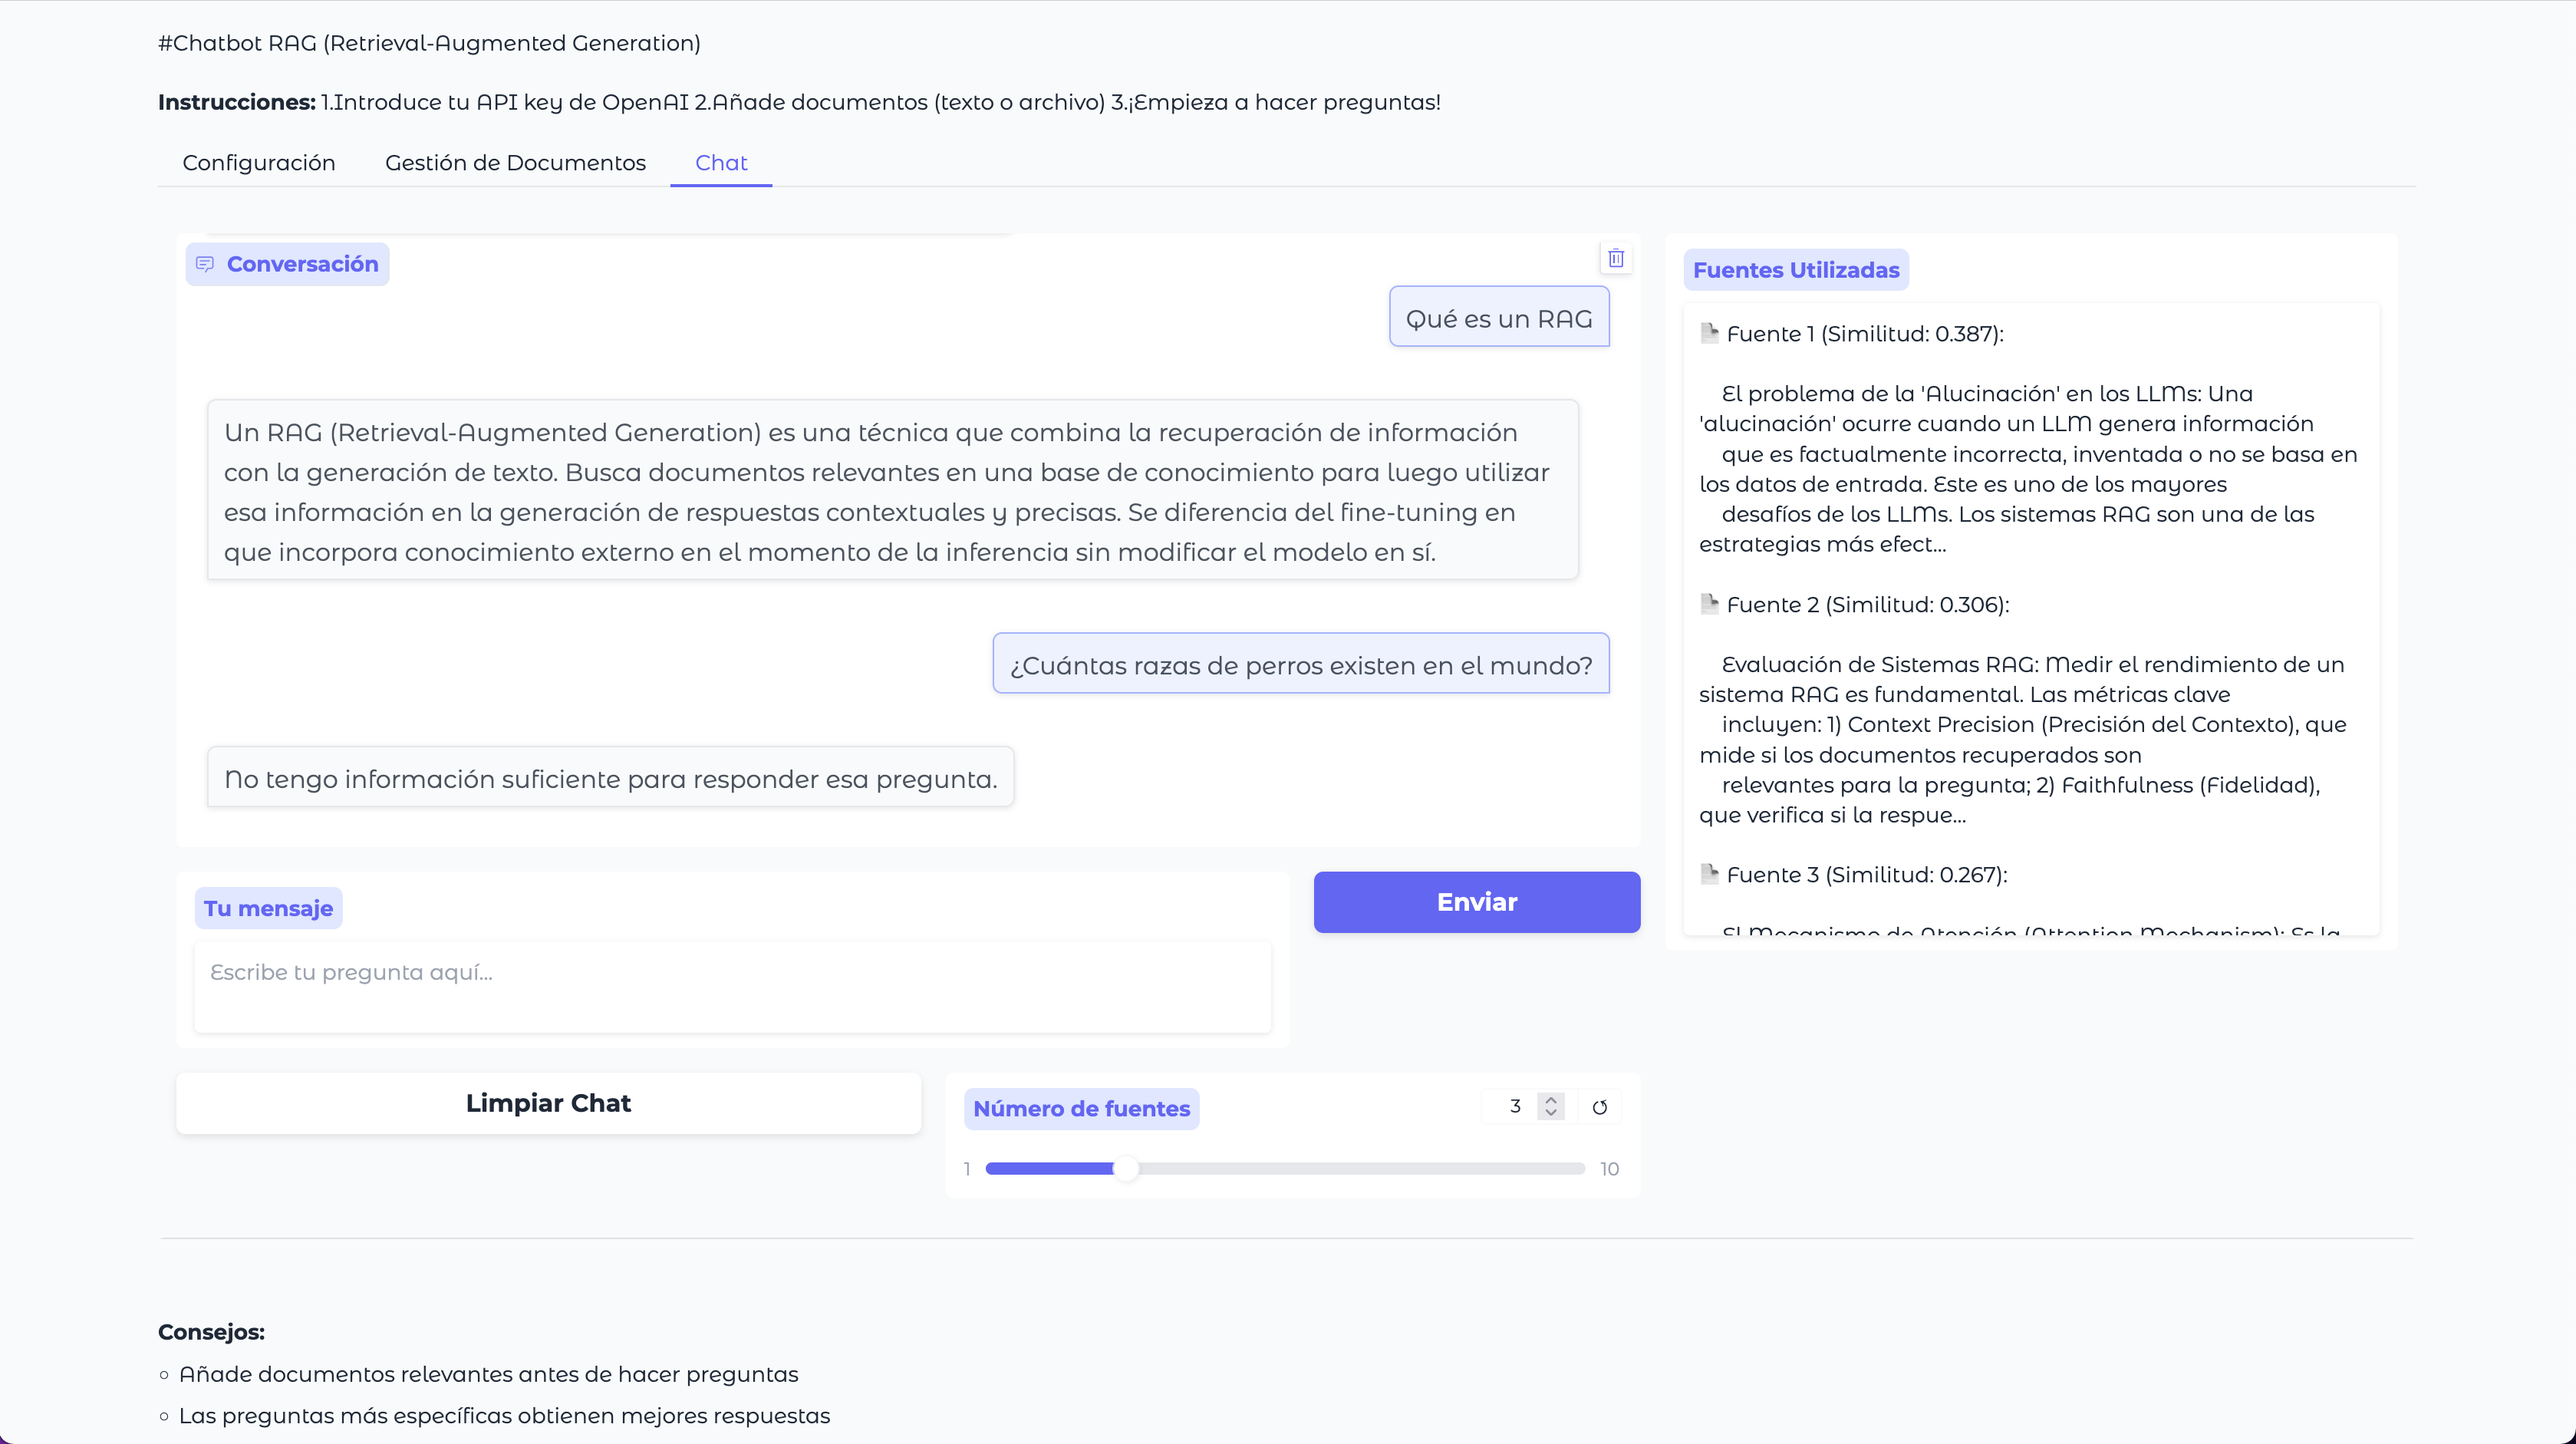

### Ejemplo de como añadir documento por texto
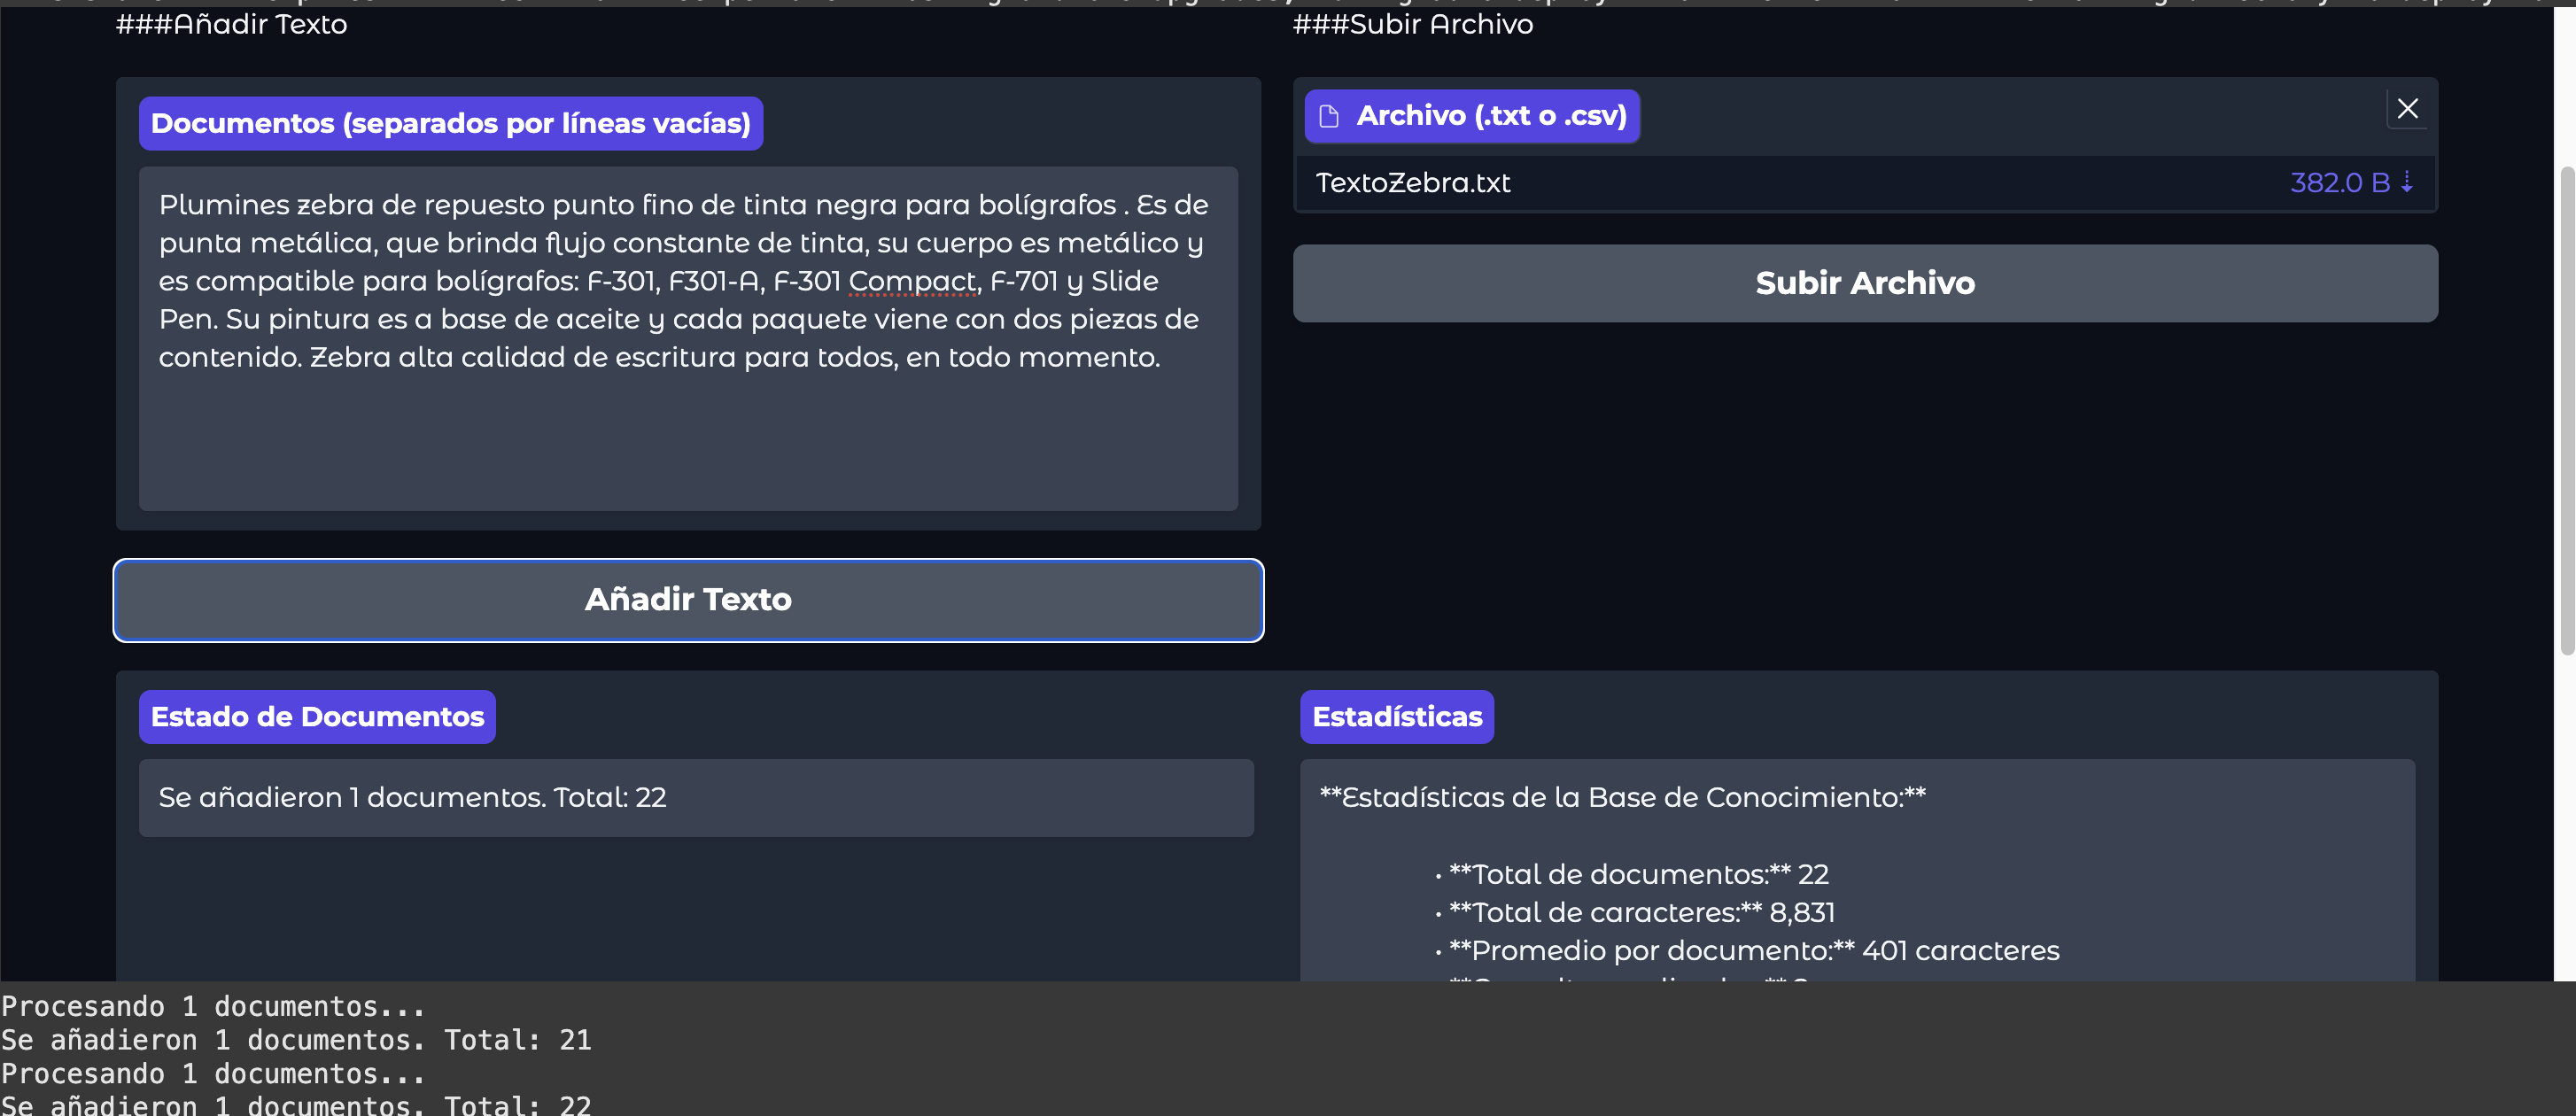

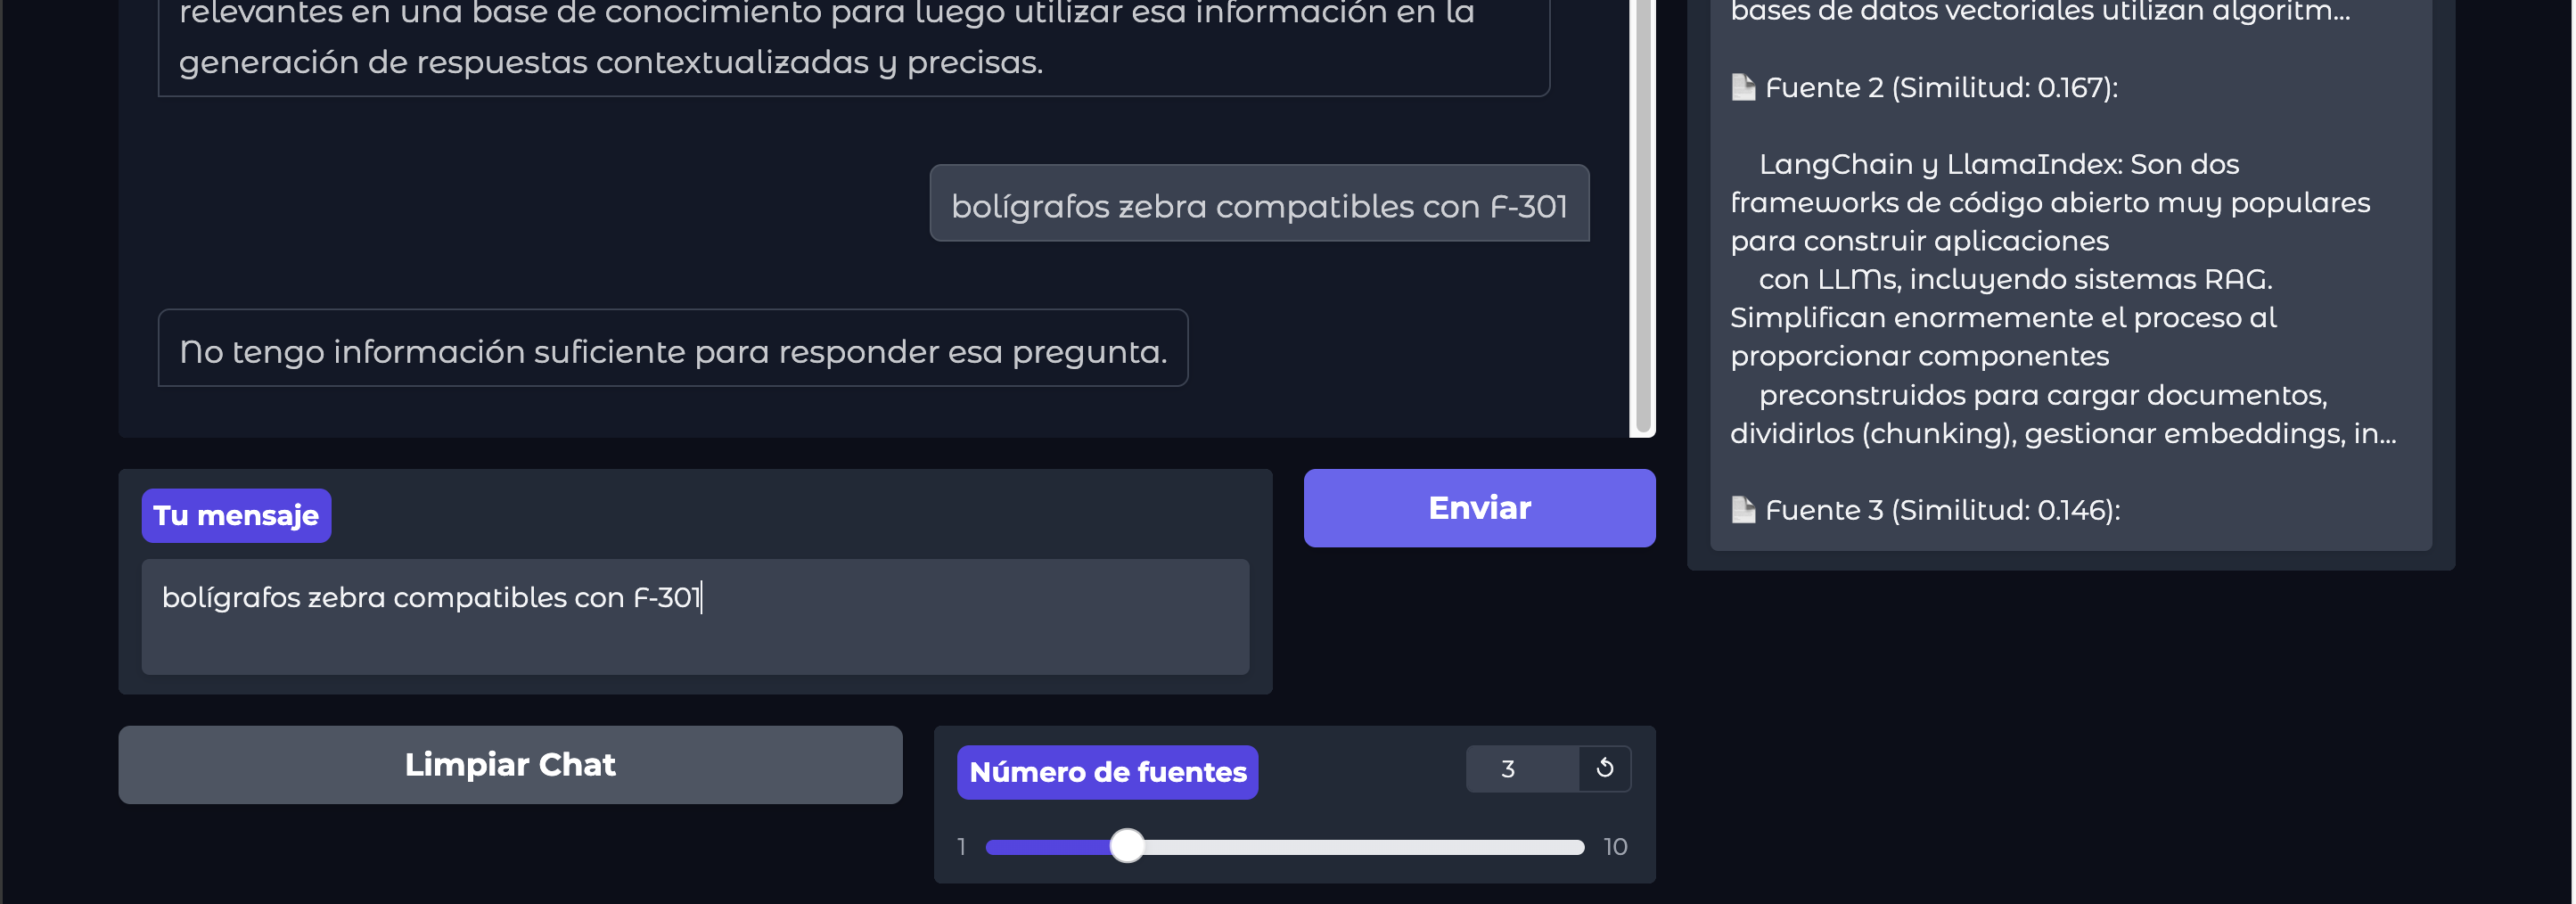

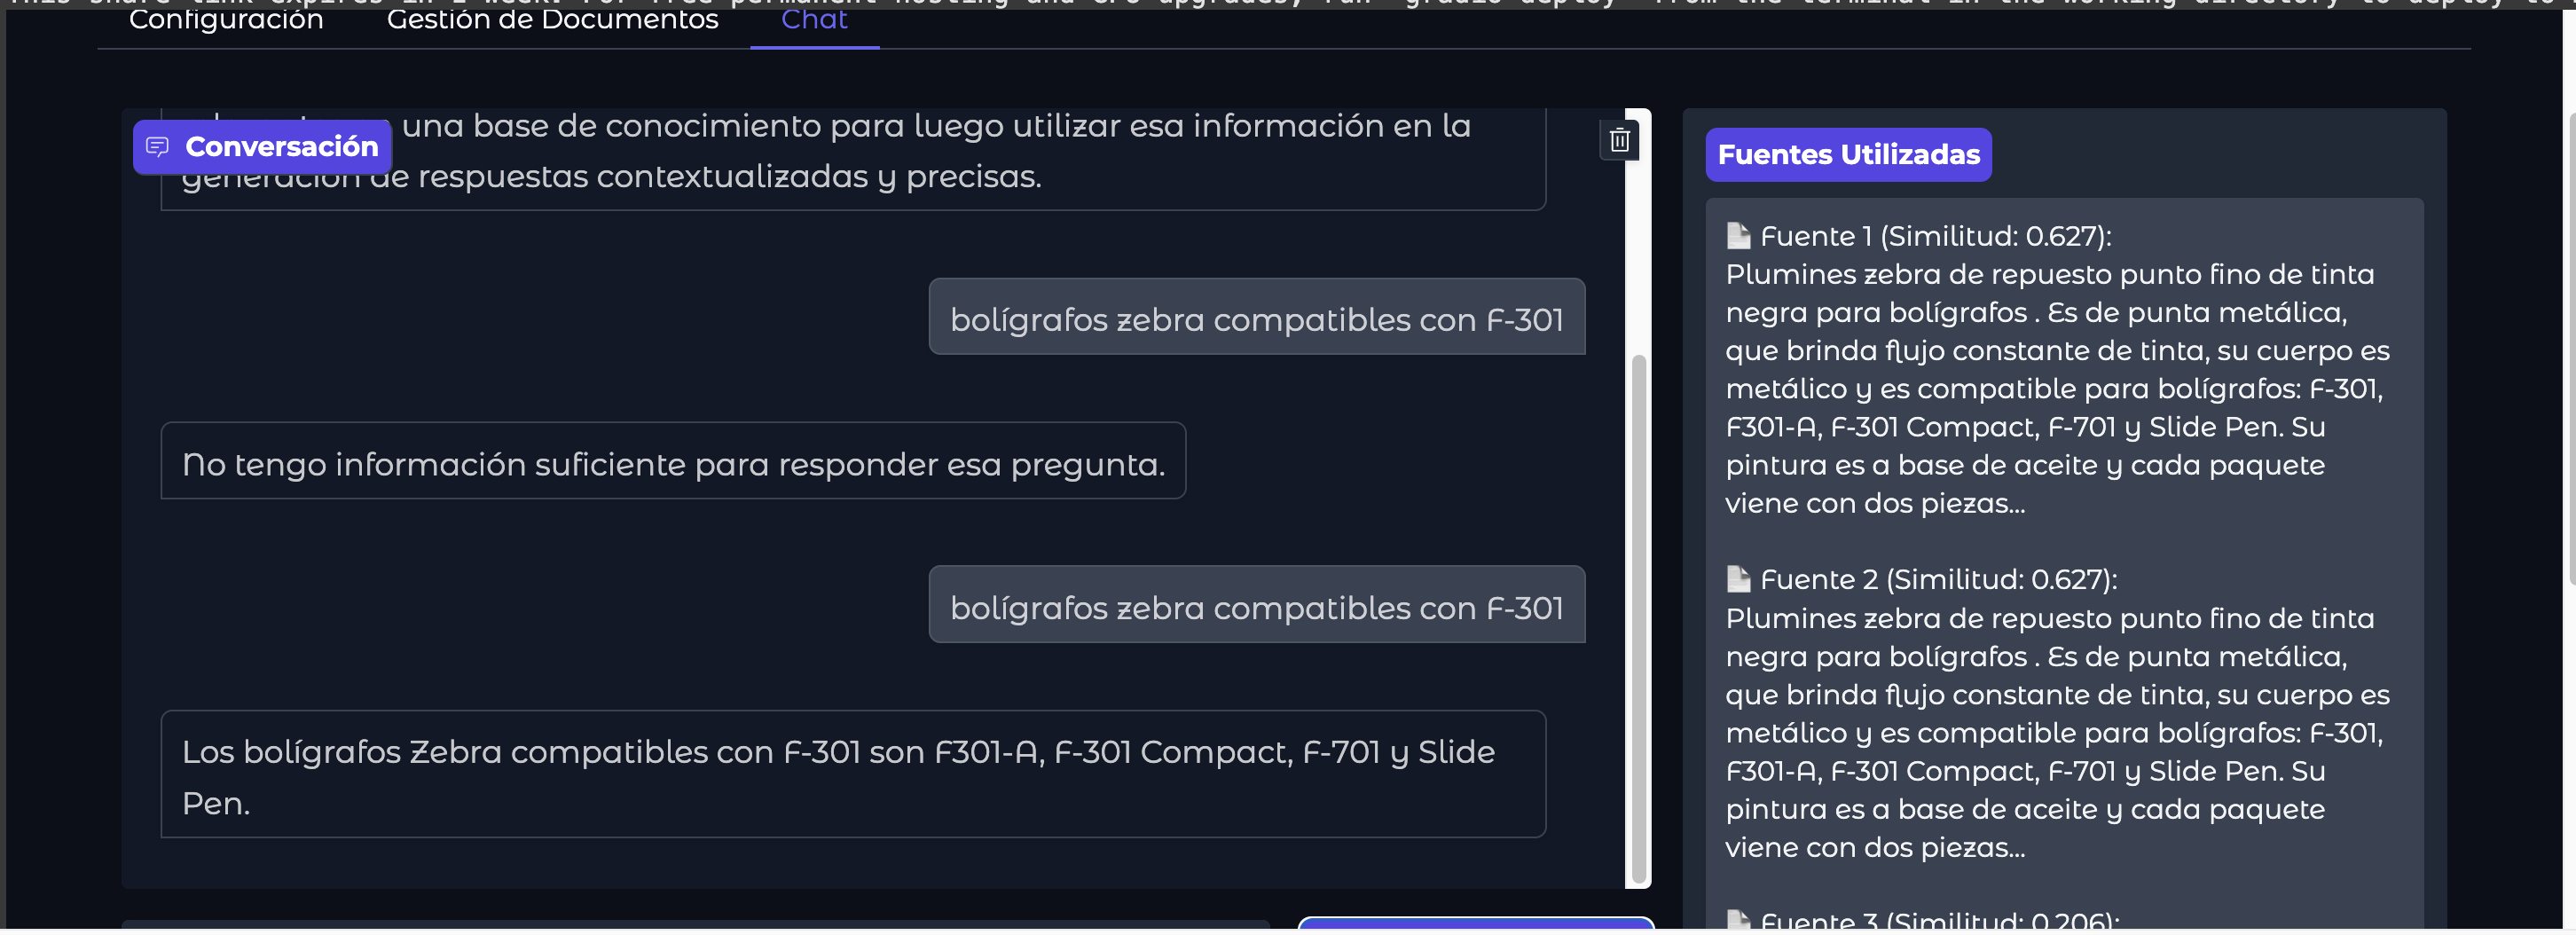


Lo que nos muestran las imágenes anteriores, es como incluimos texto de un tema distinto a RAG:
1. Capturamos el texto como se nos indica.
2. Hacemos click en el botón "Añadir Texto" el cuál al terminar de importar la información nos actualiza las estadísticas, y el estado de documentos.
3. Ahora podemos capturar un mensaje del tema que trataba texto añadido. En nuestro caso:
*   "bolígrafos zebra compatibles con F-301".
4. Obtenemos la respuesta correcta.

De lo anterior podemos destacar el uso del LLM como un modelo general, el cuál  nos serviria de base para poder generar sistemas especializados de una manera relativamente sencilla, partimos de una base probada y posteriormente solo lo alimentamos con información enfocada, de acuerdo a nuestro problema. Esto trae beneficios tales como menor necesidad de reentrenar el LLM con cada cambio y la rápida adaptabilidad de acuerdo al tema de especialización.

---
En el ejemplo de abajo, encontramos una respuesta al servicio de Amazon Kendra, la pregunta fue exitosamente respondida, pues se le agregó un documento relevante a RAG de Amazon.

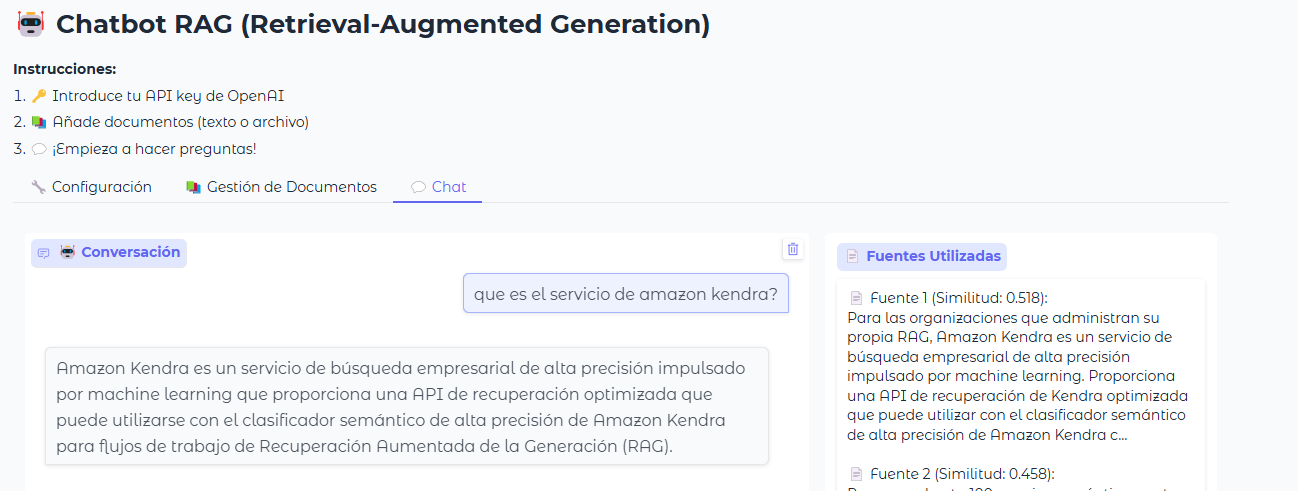



En la imagen de abajo, encontramos una respuesta fallida, pues el RAG no es para nada relevante a recetas de cocina.

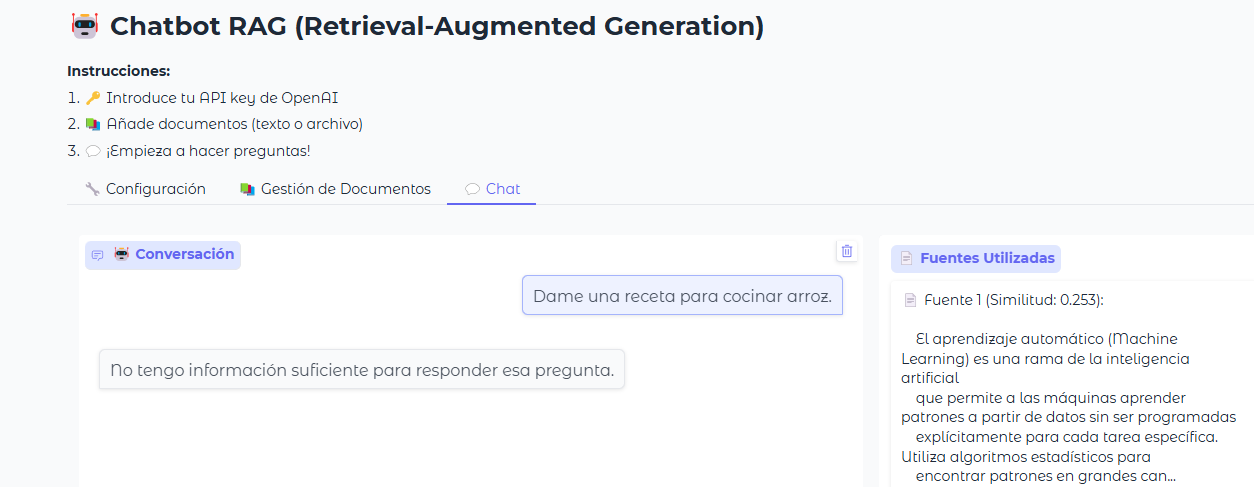

La implementación de Retrieval-Augmented Generation (RAG) utilizando el modelo de lenguaje GPT-3.5 demostró ser una estrategia eficaz para mejorar la calidad y relevancia de las respuestas generadas en tareas de pregunta-respuesta. Mediante la integración de mecanismos de recuperación de información basada en embeddings y generación automática de texto, se logró aprovechar tanto el conocimiento almacenado en bases de datos externas como la capacidad generativa avanzada del modelo LLM. Los resultados evidencian una mejora considerable en la precisión y contextualización de la información proporcionada en comparación con estrategias puramente generativas. Este enfoque resalta el potencial de sistemas híbridos para aplicaciones complejas de procesamiento de lenguaje natural, y abre nuevas oportunidades para el desarrollo de asistentes inteligentes más útiles y confiables en diversos entornos profesionales.

---

# Conclusiones

El desarrollo del chatbot basado en una arquitectura RAG (Retrieval-Augmented Generation) y un modelo LLM demostro ser efectivo para resolver preguntas concretas, que tengan alguna relacion con los documentos que se procesan en la instancia chatBot. Como pudimos observar durante tests, actualmente el modelo es capaz solo de cargar archivos txt y csv. Permitiendo enriquecer las respuestas del modelo con nuevo contexto.
<br/>

Entre los principales aprendizajes y observaciones destacamos:
<br/>

- Precisión de respuestas a preguntas que reconoce el modelo: El uso del sistema RAG permitió reducir respuestas genéricas o incorrectas por parte del modelo LLM, basadas solo en la información que contiene  el corpus.
<br/>

- Adaptacion y escalabilidad: La arquitectura construida es facil de adaptarse a la integracion de nuevos contextos pero en la parte de "escalabilidad" por motivos de desarrollo academico esta lejos de ser escalado facilmente.
Se necesitarian incluir al menos los siguientes mecanismos para comenzar a tener una mejor escalabilidad:
  1. Mecanismos para procesamiento de mas tipos de documentos. Ejem, pdf, excel, word, md, html, etc.
  2. Base de datos de tipo blob en la nube que permita la gestion de datos estructurados y no estructurados.
<br/>

- Limitaciones encontradas: Se observo que en algunos casos, el modelo puede generar respuestas incorrectas si el documento(s) que se  toman como referencia no esta lo suficientemente complementado.
<br/>

Aplicaciones futuras: Este tipo de sistemas puede implementarse de forma efectiva en contextos industriales, académicos o corporativos donde se requiere automatizar el soporte técnico, documental o formativo.

La solución desarrollada evidencia cómo los sistemas RAG+LLM representan una evolución importante en la generación de respuestas personalizadas, permitiendo construir asistentes conversacionales más útiles, precisos y aplicables en la vida real.

# **Fin de la actividad chatbot: LLM + RAG**